_This is a template for use in QFRM Bootcamp. You should save a copy on your own computer, which you will modify during the course of the bootcamp._

_When you are finished, you will have a working demonstration of what you know about modeling financial problems using Python and the Python ecosystem provided by Anaconda, which includes the NumPy, SciPy, SymPy, and PyPlot libraries._

_You can modify or delete this cell as desired._

# Risk Measurement

_In order to manage, you must first measure._

Risk management requires that you first measure risk. We are interested in managing risk at the level of a portfolio. This means our risk measures will give us information about the distribution of future profit and loss (P&L). These statistics might be standard deviation, VaR (value-at-risk), and/or ES (expected shortfall).

In this notebook, we will demonstrate how these measures are calculated. But first, we will have to demonstrate how we will get a sample distribution of portfolio P&L observations.

## Building our model

We want to forecast the future distribution of returns. So the statistical measures of our portfolio returns are not applied to historical observations. Rather, we must have a model from which we will generate sample simulations of future returns. Our model, however, is calibrated by using historical data. 

### Historical data
So we must first be able to read in _market data_, which means historical prices. There are many ways to get market data, but for our purposes, a good way is to use the _pandas_ library to access data.

_Replace these italics with a description of the data available via the pandas interface, and explain the relative merits of using Google versus Yahoo data._

In [73]:
def __fakeWebReader__(price):
    return pd.DataFrame([price, price+1, price-2, price-1], columns=['Close'], 
                        index=['2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24'])

In [90]:
# Python code demonstrating how to retrieve market data
# for multiple stock and ETF securities via pandas, and display using
# mathplotlib.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tickers = ['^GDAXI', 'SPX', 'AAPL']
prices = None
p0 = 10
for ticker in tickers:
#     df = web.DataReader(name=ticker, data_source='google',
#                    start='2015-08-20', stop='2016-08-20')['Close']
    df = __fakeWebReader__(p0)
    p0 *= 2
    df[ticker] = df['Close']
    del df['Close']
    if ticker == tickers[0]:
        prices = df
    else:
        prices = prices.join(df)

print prices

            ^GDAXI  SPX  AAPL
2015-08-21      10   20    40
2015-08-22      11   21    41
2015-08-23       8   18    38
2015-08-24       9   19    39


### Log returns
We are interested in how prices change. For several reasons, we model the price change (aka the return) as the log of the ratio of price to previous price:
$R_t = \ln \frac{P_t}{P_{t-1}}$.

              ^GDAXI       SPX      AAPL
2015-08-22  0.095310  0.048790  0.024693
2015-08-23 -0.318454 -0.154151 -0.075986
2015-08-24  0.117783  0.054067  0.025975


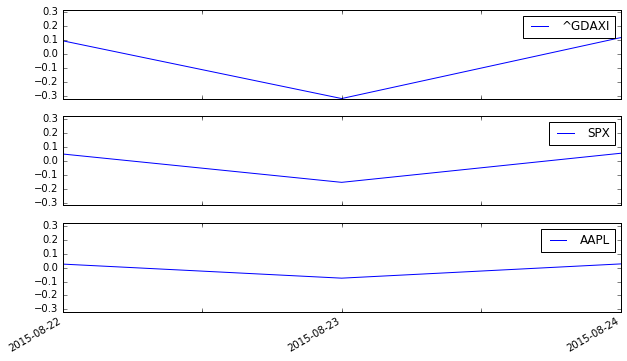

In [102]:
%matplotlib inline
returns = prices.copy() #may only need the index, could use join below
for ticker in prices.columns:
    returns[ticker] = np.log(prices[ticker] / prices[ticker].shift(1))
returns = returns[1:]
y_lim = max(abs(min(np.min(returns))), abs(max(np.max(returns))))
returns[tickers].plot(subplots=True, style='b', figsize=(10,6), ylim=(-y_lim, y_lim))
print returns

### Historical simulation of stock prices

Historical simulation applies the effects of past trading periods to today's portfolio, and observing the P&L for each of these past periods. It is an empirical distribution of price changes applied to current price levels.

A typical horizon for forecasting P&L is one day. Historical simulation applies the log price change for each trading day in our historical market dataset to our present portfolio, and notes the change in market value for each position.

_Replace these italics with a discussion of how much data to use, and the tradeoffs of using more or less data._

In [76]:
# Python code demonstrating how to apply historical price changes to the current portfolio,
# and aggregate the P&L across the portfolio for each historical period.
# We display using the histogram feature in mathplotlib.

### Monte Carlo simulation of prices

Monte Carlo simulation makes some kind of distribution assumption for the price changes. For example, we might assume that prices  follow a lognormal distribution. Since our horizon of one day is relatively short, we might reasonably assume that the mean expected log price change is small relative to the variance, so we will take it to be zero. For a security price $P$ with spot price $P_0$, we model the _return_ $R$ via

$\displaystyle R = \ln \frac{P}{P_0} \sim \rm{N}(0, \sigma^2)$.

Of course, our portfolio has multiple securities. A portfolio of $n$ stocks or ETFs will require modeling multiple returns that covary. So $R$ becomes a vector of returns, and we can write

$\displaystyle R = \left( \ln \frac{P^{(1)}}{P^{(1)}_0}, \ln \frac{P^{(2)}}{P^{(2)}_0}, , ...,\ln \frac{P^{(n)}}{P^{(n)}_0} \right) \sim \rm{N}(0, \Sigma)$

where $\Sigma$ is an $n \times n$ covariance matrix.

To generate correlated returns, suppose we can find an $n \times k$  decomposition $M$ of the covariance matrix, $\Sigma = MM'$. Then for a vector of independent standard normal random variables $\rm{z} \in \Re^k$, it turns out that $M \rm{z} \sim \rm{N}(0, \Sigma)$. So $R$ and $M \rm{z}$ have the same distribution. The NumPy library provides standard normal random numbers. We just need to find a decomposition $M$ of the covariance matrix.  

#### Cholesky decomposition

The Cholesky decomposition finds just such a decomposition, provided $\Sigma$ is symmetric, and PSD (positive semi-definite), which it is. So we first need to compute the covariance matrix. 

_Replace these italics with a description of the procedure for calculating covariance._

In [77]:
# Python code demonstrating how to calculute the covariance matrix of the log returns.

The Cholesky decomposition is provided by the NumPy library.

In [78]:
# Python code demonstrating Cholesky decomposition of the previously computed covariance matrix.

Now, we put together the decomposition with NumPy's standard normal randoms to get multivariate normal returns.

In [79]:
# Python code demonstrating generating MVN returns via Cholesky decomposition. 
# For our 3 stock example, we demonstrate the covariance with scatterplots of paired returns. 

#### Decomposing covariance without calculating covariance

While calculating the Cholesky decomposition is easy via NumPy, it has its potential drawbacks. An alternative method used by RiskMetrics exploits the fact that with a small adjustment, historical returns provide a decomposition that addresses these drawbacks. 

_Replace these italics with a description of potential drawbacks of the Cholesky decomposition, and when it is appropriate to use the RiskMetrics method._

In [80]:
# Python code demonstrating generating MVN returns. For our 3 stock example, we demonstrate
# the covariance with scatterplots of paired returns. 

## Generating a P&L distribution

We have our model of the market. Now we need to turn these simulated returns into prices, and then into P&L. 

_Replace these italics with a description of how we get P&L on each stock holding, given the simulated log return._

In [81]:
# Python code demonstrating getting P&L on each position, aggregated into portfolio P&L,
# then plotted in a histogram.

## Calculating risk statistics

We have our distribution of P&L. Now we wish to calculated the standard deviation, VaR, and ES.

_Replace these italics with a description of how we calculate these statistics._

In [82]:
# Python code demonstrating calculating risk statistics on our portfolio.